In [1]:
# Import the Required Packages
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import csv
import os

## Step 1: Data Loading

In [2]:
train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')
validation_dir = os.path.join(os.getcwd(), 'validation')

### VGG16 PRETRAIN MODEL Base

In [3]:

img_size = 224

from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

In [4]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Feature extraction without data augmentation With VGG16

In [5]:
# features shape need to follow model last layer
# Need to add a comma and 10 for labels shape as there are 10 classes for the dataset

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count,10))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [6]:
train_features, train_labels = extract_features(train_dir, 7500)
validation_features, validation_labels = extract_features(validation_dir, 2000)
test_features, test_labels = extract_features(test_dir, 500)

Found 7500 images belonging to 10 classes.
1/1 [==============================] - 2s 2s/step
Found 2000 images belonging to 10 classes.
1/1 [==============================] - 2s 2s/step
Found 500 images belonging to 10 classes.
1/1 [==============================] - 3s 3s/step


In [7]:
print(train_features.shape)
print(train_labels.shape)

(7500, 7, 7, 512)
(7500, 10)


In [8]:
train_features = np.reshape(train_features, (7500, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (2000, 7 * 7 * 512))
test_features = np.reshape(test_features, (500, 7 * 7 * 512))

### Building the Model 

In [9]:
vgg_base.trainable = False

vgg_1 = models.Sequential()
vgg_1.add(layers.Dense(256, activation='relu', input_shape=(7 * 7 * 512,)))
vgg_1.add(layers.Dense(10, activation='softmax'))

vgg_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 6,425,354
Trainable params: 6,425,354
Non-trainable params: 0
_________________________________________________________________


In [10]:
vgg_1.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [11]:
# Train the Model
from keras.callbacks import ModelCheckpoint

# Checkpoint
mc = ModelCheckpoint(
    'VGG16_no_augmentation.keras',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True
)


history = vgg_1.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=32,
                    callbacks=[mc],
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
224/235 [===========================>..] - ETA: 0s - loss: 1.6309 - acc: 0.5243
Epoch 1: val_loss improved from inf to 1.08848, saving model to VGG16_no_augmentation.keras
235/235 [==============================] - 2s 7ms/step - loss: 1.6064 - acc: 0.5304 - val_loss: 1.0885 - val_acc: 0.6480
Epoch 2/30
234/235 [============================>.] - ETA: 0s - loss: 0.7215 - acc: 0.7662
Epoch 2: val_loss improved from 1.08848 to 0.94518, saving model to VGG16_no_augmentation.keras
235/235 [==============================] - 1s 5ms/step - loss: 0.7213 - acc: 0.7661 - val_loss: 0.9452 - val_acc: 0.6790
Epoch 3/30
234/235 [============================>.] - ETA: 0s - loss: 0.4390 - acc: 0.8671
Epoch 3: val_loss did not improve from 0.94518
235/235 [==============================] - 1s 5ms/step - loss: 0.4385 - acc: 0.8672 - val_loss: 0.9972 - val_acc: 0.6835
Epoch 4/30
233/235 [============================>.] - ETA: 0s - loss: 0.2308 - acc: 0.9450
Epoch 4: val_loss did not improve from

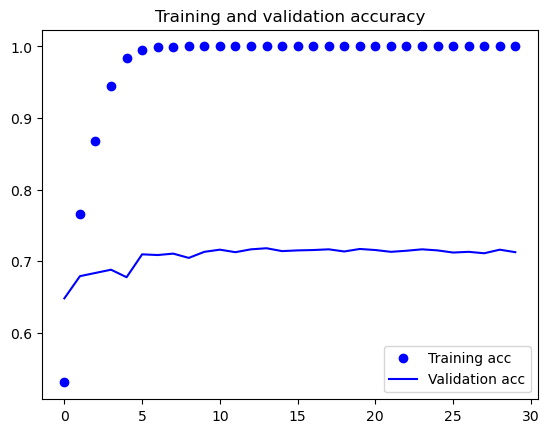

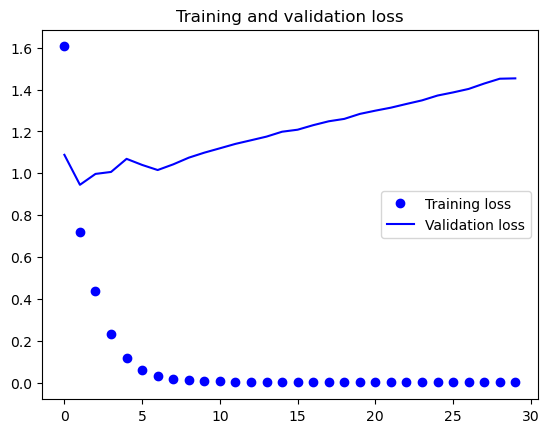

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()